# Regression models to predict Happiness Score

In [24]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import objects as so

In [25]:
df = pd.read_csv('../data/processed/WorldHappiness2015_2022.csv')
df

,Year,Country,Happiness Rank,Happiness Score,Freedom,Generosity,Healthy life expectancy,Perceptions of corruption,GDP per capita,Social support,Dystopia Residual,Region
0,2015,Switzerland,1,7.587,0.66557,0.29678,0.94143,0.41978,1.39651,1.422681,2.51738,Western Europe
1,2015,Iceland,2,7.561,0.62877,0.43630,0.94784,0.14145,1.30232,1.461513,2.70201,Western Europe
2,2015,Denmark,3,7.527,0.64938,0.34139,0.87464,0.48357,1.32548,1.403490,2.49204,Western Europe
3,2015,Norway,4,7.522,0.66973,0.34699,0.88521,0.36503,1.45900,1.401235,2.46531,Western Europe
4,2015,Canada,5,7.427,0.63297,0.45811,0.90563,0.32957,1.32629,1.340878,2.45176,North America
...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2022,Botswana,142,3.471,0.57100,0.01200,0.28000,0.10200,1.50300,0.815000,0.18700,Sub-Saharan Africa
1226,2022,Rwanda,143,3.268,0.62100,0.18700,0.46200,0.54400,0.78500,0.133000,0.53600,Sub-Saharan Africa
1227,2022,Zimbabwe,144,2.995,0.32900,0.10600,0.27000,0.10500,0.94700,0.690000,0.54800,Sub-Saharan Africa
1228,2022,Lebanon,145,2.955,0.10300,0.08200,0.63100,0.03400,1.39200,0.498000,0.21600,Middle East and Northern Africa


In [26]:
df['Country'] = df['Country'].astype('category')
df['Region'] = df['Region'].astype('category')

In [27]:
from sklearn.model_selection import train_test_split

# Cross Validation for Happiness Score
X = df.drop('Happiness Score', axis=1)
y = df['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Scores Dataframe
score_df = pd.DataFrame(columns = [
    'regressor',
    'mae',
    'mse',
    'rmse',
    'r2_score',
    'cross_val'
])

### Metrics

Common evaluation metrics for regression problems:

- Mean Absolute Error (MAE): mean of the absolute value of the errors: 1n∑i=1n|yi−y^i|. It is the easiest to understand, because it's the average error.
- Mean Squared Error (MSE): mean of the squared errors: 1n∑i=1n(yi−y^i)^2. It is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- Root Mean Squared Error (RMSE): square root of the mean of the squared errors: 1n∑i=1n(yi−y^i)^2. RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of the previous are loss functions, because we want to minimize them.

- accuracy: calculates the closseness of preditions to real values by residuals. The higher the accuracy the better. 
- r2_score: means how good a regression model fitted the data (regression score function). Best possible score is 1.0. = accuracy
- Cross Validation: devides the data into k-folds, selecting one as the test data and the rest as training, iterating for each fold. How to interpret 

In [6]:
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_val_score
import numpy as np


def evaluate(regressor, model, X, y, true, predicted, cv=True):
    kfold = model_selection.KFold(n_splits=5)
    return {
        'regressor': regressor,
        'mae': metrics.mean_absolute_error(true, predicted), 
        'mse': metrics.mean_squared_error(true, predicted), 
        'rmse': np.sqrt(metrics.mean_squared_error(true, predicted)), 
        'r2_score': metrics.r2_score(true, predicted),
        'cross_val': cross_val_score(model, X, y, cv=kfold).mean() if cv else None
    }

In [7]:
# Graph
def graph(real, predicted):
    X = list(range(0, len(real)))
    df1 = pd.DataFrame(data={
        "X": X,
        "y":real,
        "origin":'real'
    })
    df2 = pd.DataFrame(data={
        "X": X,
        "y":predicted,
        "origin":'predicted'
    })

    data = pd.concat([df1, df2]).reset_index(drop=True)

    return (
        so.Plot(data=data, x='X', y='y', color='origin', marker="origin")
        .add(so.Dots())
        .scale(
            color=['#87b7e0', '#cf604a'],
            marker=so.Nominal(["o", "x"]),
        )
    )

### Transformers

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector as selector

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
poly_transformer =  PolynomialFeatures(degree=2)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

preprocessor_cat = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

linear_regression = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

linear_regression.fit(X_train, y_train)
# accuracy = linear_regression.score(X_test, y_test)

# evaluate
test_pred = linear_regression.predict(X_test)
scores = evaluate("linear regression", linear_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'linear regression',
 'mae': 0.07637827156684145,
 'mse': 0.01125604531205027,
 'rmse': 0.10609451122489924,
 'r2_score': 0.9906895124193515,
 'cross_val': 0.984023300927708}

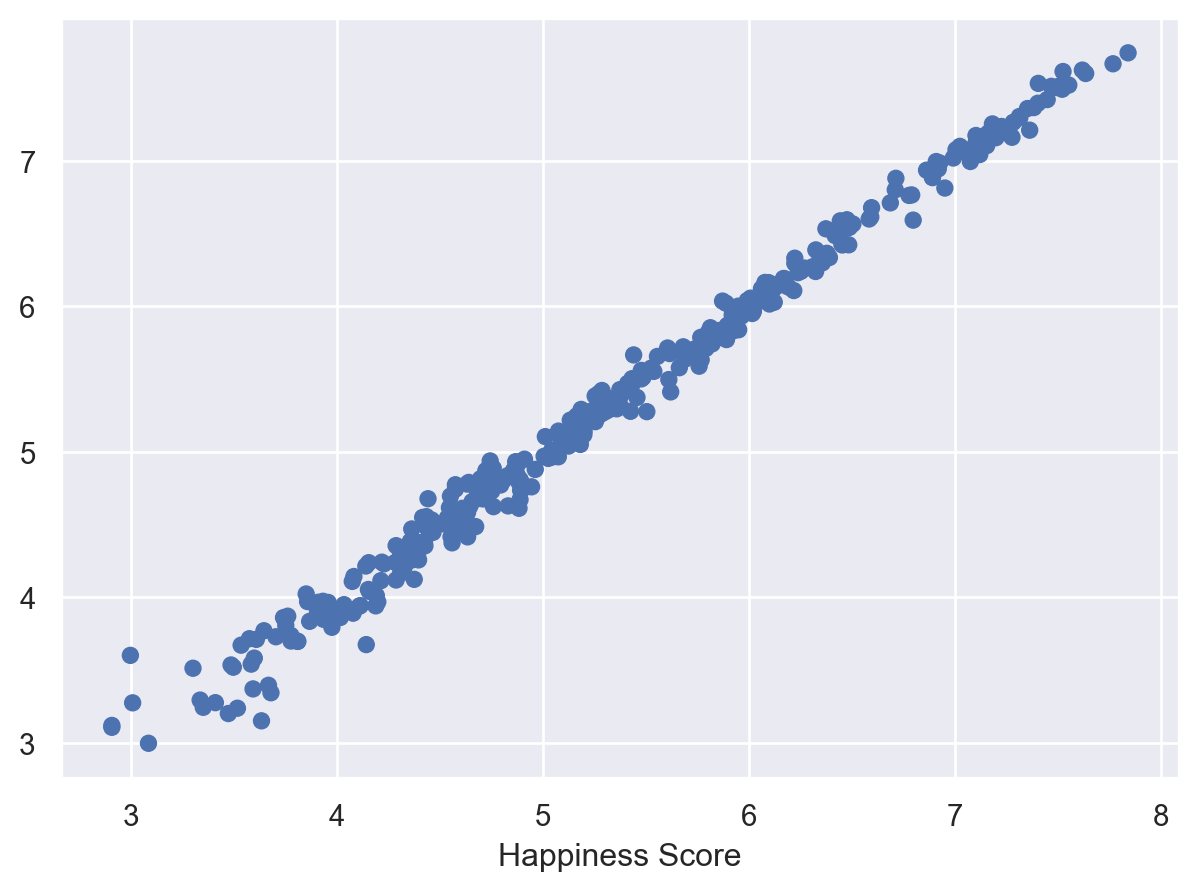

In [10]:
(
    so.Plot(x=y_test, y=test_pred)
    .add(so.Dot())
)

### Ridge Regression

In [11]:
from sklearn.linear_model import Ridge

ridge_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", Ridge(alpha=100, solver='auto', tol=0.0001, random_state=42))]
)

ridge_regression.fit(X_train, y_train)
# ridge_regression.score(X_test, y_test)

# evaluate
test_pred = ridge_regression.predict(X_test)
scores = evaluate("ridge regression", ridge_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'ridge regression',
 'mae': 0.6182467889593948,
 'mse': 0.5909679461199013,
 'rmse': 0.7687443958299152,
 'r2_score': 0.5111782539627628,
 'cross_val': 0.5009422733819344}

### Lasso Regression

In [12]:
from sklearn.linear_model import Lasso

lasso_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=42))]
    )

lasso_regression.fit(X_train, y_train)
# lasso_regression.score(X_test, y_test)

# evaluate
test_pred = lasso_regression.predict(X_test)
scores = evaluate("lasso regression", lasso_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'lasso regression',
 'mae': 0.847885379489352,
 'mse': 1.0243305705635661,
 'rmse': 1.0120921749344602,
 'r2_score': 0.15272044565237408,
 'cross_val': 0.13878859962664875}

### Polynomial Regression

In [13]:
poly_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("polynomial", poly_transformer), ("regressor", LinearRegression())]
    )

poly_regression.fit(X_train, y_train)
# poly_regression.score(X_test, y_test)

# evaluate
test_pred = poly_regression.predict(X_test)
scores = evaluate("polynomial regression", poly_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'polynomial regression',
 'mae': 0.2173519625491925,
 'mse': 0.08652153998271574,
 'rmse': 0.29414544018684996,
 'r2_score': 0.9284333261696045,
 'cross_val': 0.8925742623637047}

### Stochastic Gradient Descent

In [14]:
from sklearn.linear_model import SGDRegressor

sgrad_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000))]
    )

sgrad_regression.fit(X_train, y_train)
# sgrad_regression.score(X_test, y_test) 

# evaluate
test_pred = sgrad_regression.predict(X_test)
scores = evaluate("stochastic gradient descent", sgrad_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'stochastic gradient descent',
 'mae': 1.68291413161828,
 'mse': 4.374609251345204,
 'rmse': 2.0915566574552082,
 'r2_score': -2.618477358227739,
 'cross_val': -2.5906282418299944}

### SVR

In [15]:
from sklearn.svm import SVR

svm_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", SVR(kernel='rbf', C=1000000, epsilon=0.001))]
    )

svm_regression.fit(X_train, y_train)
# svm_regression.score(X_test, y_test)

# evaluate
test_pred = svm_regression.predict(X_test)
scores = evaluate("svm regression", svm_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'svm regression',
 'mae': 0.2326890317125201,
 'mse': 0.10194783871078288,
 'rmse': 0.3192927163447091,
 'r2_score': 0.9156733950622482,
 'cross_val': 0.8774347366036181}

### Regression Tree

In [16]:
from sklearn.tree import DecisionTreeRegressor

regression_tree = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", DecisionTreeRegressor(max_depth=2))]
    )

regression_tree.fit(X_train, y_train)
# regression_tree.score(X_test, y_test)

# evaluate
test_pred = regression_tree.predict(X_test)
scores = evaluate("regression tree", regression_tree, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'regression tree',
 'mae': 0.6218486881531944,
 'mse': 0.5928799324726384,
 'rmse': 0.769986969027813,
 'r2_score': 0.5095967460087685,
 'cross_val': 0.4684553645319475}

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

randforest_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", RandomForestRegressor(n_estimators=1000))]
    )

randforest_regression.fit(X_train, y_train)
# randforest_regression.score(X_test, y_test)

# evaluate
test_pred = randforest_regression.predict(X_test)
scores = evaluate("random forest", randforest_regression, X, y, y_test, test_pred)
score_df = score_df.append(scores, ignore_index=True)
scores

{'regressor': 'random forest',
 'mae': 0.2181002360724304,
 'mse': 0.08575707539068325,
 'rmse': 0.29284309005111125,
 'r2_score': 0.9290656564323784,
 'cross_val': 0.8924500674274845}

### Neural Networks

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

df2 = df.copy()
df2['Country'] = df2['Country'].astype('category').cat.codes
df2['Region'] = df2['Region'].astype('category').cat.codes

# Cross Validation for Happiness Score
X = df2.drop('Happiness Score', axis=1)
y = df2['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

nn = Sequential()

nn.add(Dense(X_train.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
# nn.add(Dropout(0.2))

nn.add(Dense(64, activation='relu'))
# nn.add(Dropout(0.2))

nn.add(Dense(128, activation='relu'))
# nn.add(Dropout(0.2))

nn.add(Dense(512, activation='relu'))
nn.add(Dropout(0.1))
nn.add(Dense(1))

nn.compile(optimizer=Adam(0.00001), loss='mse')

r = nn.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

test_pred = nn.predict(X_test)
scores = evaluate("neural networks", nn, X, y, y_test, test_pred, cv=False)
score_df = score_df.append(scores, ignore_index=True,)
scores

Epoch 1/100
861/861 [==============================] - 4s 3ms/step - loss: 197.3112 - val_loss: 10.9990
Epoch 2/100
861/861 [==============================] - 3s 3ms/step - loss: 159.3143 - val_loss: 17.5802
Epoch 3/100
861/861 [==============================] - 2s 3ms/step - loss: 118.7501 - val_loss: 2.2502
Epoch 4/100
861/861 [==============================] - 3s 3ms/step - loss: 93.6285 - val_loss: 2.7944
Epoch 5/100
861/861 [==============================] - 2s 3ms/step - loss: 75.7981 - val_loss: 1.2201
Epoch 6/100
861/861 [==============================] - 3s 3ms/step - loss: 67.8908 - val_loss: 1.7619
Epoch 7/100
861/861 [==============================] - 2s 3ms/step - loss: 49.9047 - val_loss: 3.2197
Epoch 8/100
861/861 [==============================] - 3s 3ms/step - loss: 45.6242 - val_loss: 2.0706
Epoch 9/100
861/861 [==============================] - 3s 3ms/step - loss: 35.7644 - val_loss: 0.6494
Epoch 10/100
861/861 [==============================] - 3s 3ms/step - loss: 2

{'regressor': 'neural networks',
 'mae': 0.09343806197956304,
 'mse': 0.014540020303152374,
 'rmse': 0.12058200654804337,
 'r2_score': 0.9879731580051522,
 'cross_val': None}

## Comparison

In [19]:
score_df

,regressor,mae,mse,rmse,r2_score,cross_val
0,linear regression,0.076378,0.011256,0.106095,0.990690,0.984023
1,ridge regression,0.618247,0.590968,0.768744,0.511178,0.500942
2,lasso regression,0.847885,1.024331,1.012092,0.152720,0.138789
3,polynomial regression,0.217352,0.086522,0.294145,0.928433,0.892574
4,stochastic gradient descent,1.682914,4.374609,2.091557,-2.618477,-2.590628
5,svm regression,0.232689,0.101948,0.319293,0.915673,0.877435
6,regression tree,0.621849,0.592880,0.769987,0.509597,0.468455
7,random forest,0.218100,0.085757,0.292843,0.929066,0.89245
8,neural networks,0.093438,0.014540,0.120582,0.987973,None


In [20]:
# Sort by r2_square
score_df.sort_values('r2_score', ascending=False)

,regressor,mae,mse,rmse,r2_score,cross_val
0,linear regression,0.076378,0.011256,0.106095,0.990690,0.984023
8,neural networks,0.093438,0.014540,0.120582,0.987973,None
7,random forest,0.218100,0.085757,0.292843,0.929066,0.89245
3,polynomial regression,0.217352,0.086522,0.294145,0.928433,0.892574
5,svm regression,0.232689,0.101948,0.319293,0.915673,0.877435
1,ridge regression,0.618247,0.590968,0.768744,0.511178,0.500942
6,regression tree,0.621849,0.592880,0.769987,0.509597,0.468455
2,lasso regression,0.847885,1.024331,1.012092,0.152720,0.138789
4,stochastic gradient descent,1.682914,4.374609,2.091557,-2.618477,-2.590628


Linear Regression and Neural Networks are the models that best fit the data and predict Happiness Score

### Model Tuning 

In [21]:
from sklearn.model_selection import GridSearchCV

df2 = df.copy()
df2['Country'] = df2['Country'].astype('category').cat.codes
df2['Region'] = df2['Region'].astype('category').cat.codes

# Cross Validation for Happiness Score
X = df2.drop('Happiness Score', axis=1)
y = df2['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Linear Regression
param_grid = {
    'fit_intercept': [True, False],
    'n_jobs': [1, -1],
    'positive': [True, False]
}
CV_rf = GridSearchCV(estimator = LinearRegression(), param_grid = param_grid, cv=5, verbose=0)
best_model = CV_rf.fit(X_train, y_train)

print('Best Parameters', CV_rf.best_params_)

Best Parameters {'fit_intercept': True, 'n_jobs': 1, 'positive': False}


Best parameters are the default ones

In [23]:
# Ridge Regression
param_grid = {
    'alpha': [1.0, 0.5],
    'fit_intercept': [True, False],
    'max_iter': [1000, 10000, 15000],
    'tol': [0.00001, 0.0001, 0.001, 0.1],
    'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'positive': [True, False],
    'random_state': [1, 2, 3, 4, 5, 6, 7, 8]
}
CV_rf = GridSearchCV(estimator = Ridge(), param_grid = param_grid, cv=5, verbose=0)
best_model = CV_rf.fit(X_train, y_train)

print('Best Parameters', CV_rf.best_params_)

c:\Users\gabis\anaconda3\envs\py3.9.12\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gabis\anaconda3\envs\py3.9.12\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gabis\anaconda3\envs\py3.9.12\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gabis\anaconda3\envs\py3.9.12\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gabis\anaconda3\envs\py3.9.12\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\gabis\anaconda3\envs\py3.9.12\l

Best Parameters {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 1, 'solver': 'lsqr', 'tol': 1e-05}


c:\Users\gabis\anaconda3\envs\py3.9.12\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.95225796 0.9191441  0.91564998 ...        nan        nan        nan]
  warnings.warn(


Best Parameters {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 1, 'solver': 'lsqr', 'tol': 1e-05}